# Extract RB number from randomized experiments

Load the experiment `.gst` files and find experiments equivalent to the `Id` operation

In [1]:
using Glob, PyPlot

using PyCall
@pyimport seaborn as sns

rcParams = PyPlot.PyDict(PyPlot.matplotlib["rcParams"])
rcParams["figure.dpi"] = 300;

300

In [2]:
include("../scripts/RB.jl");

INFO: Precompiling module Calculus.
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] uuid4(::MersenneTwister) at ./deprecated.jl:57
 [3] msg_header at /home/jovyan/.julia/v0.6/IJulia/src/msg.jl:18 [inlined]
 [4] msg_pub(::IJulia.Msg, ::String, ::Dict{String,String}, ::Dict{String,Any}) at /home/jovyan/.julia/v0.6/IJulia/src/msg.jl:30 (repeats 2 times)
 [5] send_stream(::String) at /home/jovyan/.julia/v0.6/IJulia/src/stdio.jl:172
 [6] send_stdio(::String) at /home/jovyan/.julia/v0.6/IJulia/src/stdio.jl:130
 [7] (::Base.##302#303{IJulia.#send_stderr,Timer})() at ./event.jl:436
while loading /home/jovyan/.julia/v0.6/LsqFit/src/LsqFit.jl, in expression starting on line 7
INFO: Precompiling module Distributions.
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] uuid4(::MersenneTwister) at ./deprecated.jl:57
 [3] msg_header at /home/jovyan/.julia/v0.6/IJulia/src/msg.jl:18 [inlined]
 [4] msg_pub(::IJulia.Msg, ::String, ::Dict{String,String}, ::Dict

fit_RB

In [3]:
files = Glob.glob("../data/rgst_[1-7].gst");

Found RB number 0.00749467943882317 for file ../data/rgst_1.gst
Error: 0.000592770207071969
Found RB number 0.008002726857431797 for file ../data/rgst_2.gst
Error: 0.00045062056423220647


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] uuid4(::MersenneTwister) at ./deprecated.jl:57
 [3] msg_header at /home/jovyan/.julia/v0.6/IJulia/src/msg.jl:18 [inlined]
 [4] msg_pub(::IJulia.Msg, ::String, ::Dict{String,String}, ::Dict{String,Any}) at /home/jovyan/.julia/v0.6/IJulia/src/msg.jl:30 (repeats 2 times)
 [5] send_stream(::String) at /home/jovyan/.julia/v0.6/IJulia/src/stdio.jl:172
 [6] send_stdio(::String) at /home/jovyan/.julia/v0.6/IJulia/src/stdio.jl:130
 [7] (::Base.##302#303{IJulia.#send_stdout,Timer})() at ./event.jl:436
while loading In[18], in expression starting on line 3


Found RB number 0.0074202033313974574 for file ../data/rgst_3.gst
Error: 0.0004621887800334749
Found RB number 0.007289581987542186 for file ../data/rgst_4.gst
Error: 0.00039193454289467564
Found RB number 0.007611355632031091 for file ../data/rgst_5.gst
Error: 0.0006248832130124558
Found RB number 0.0076782099967172635 for file ../data/rgst_6.gst
Error: 0.00019780925119446894


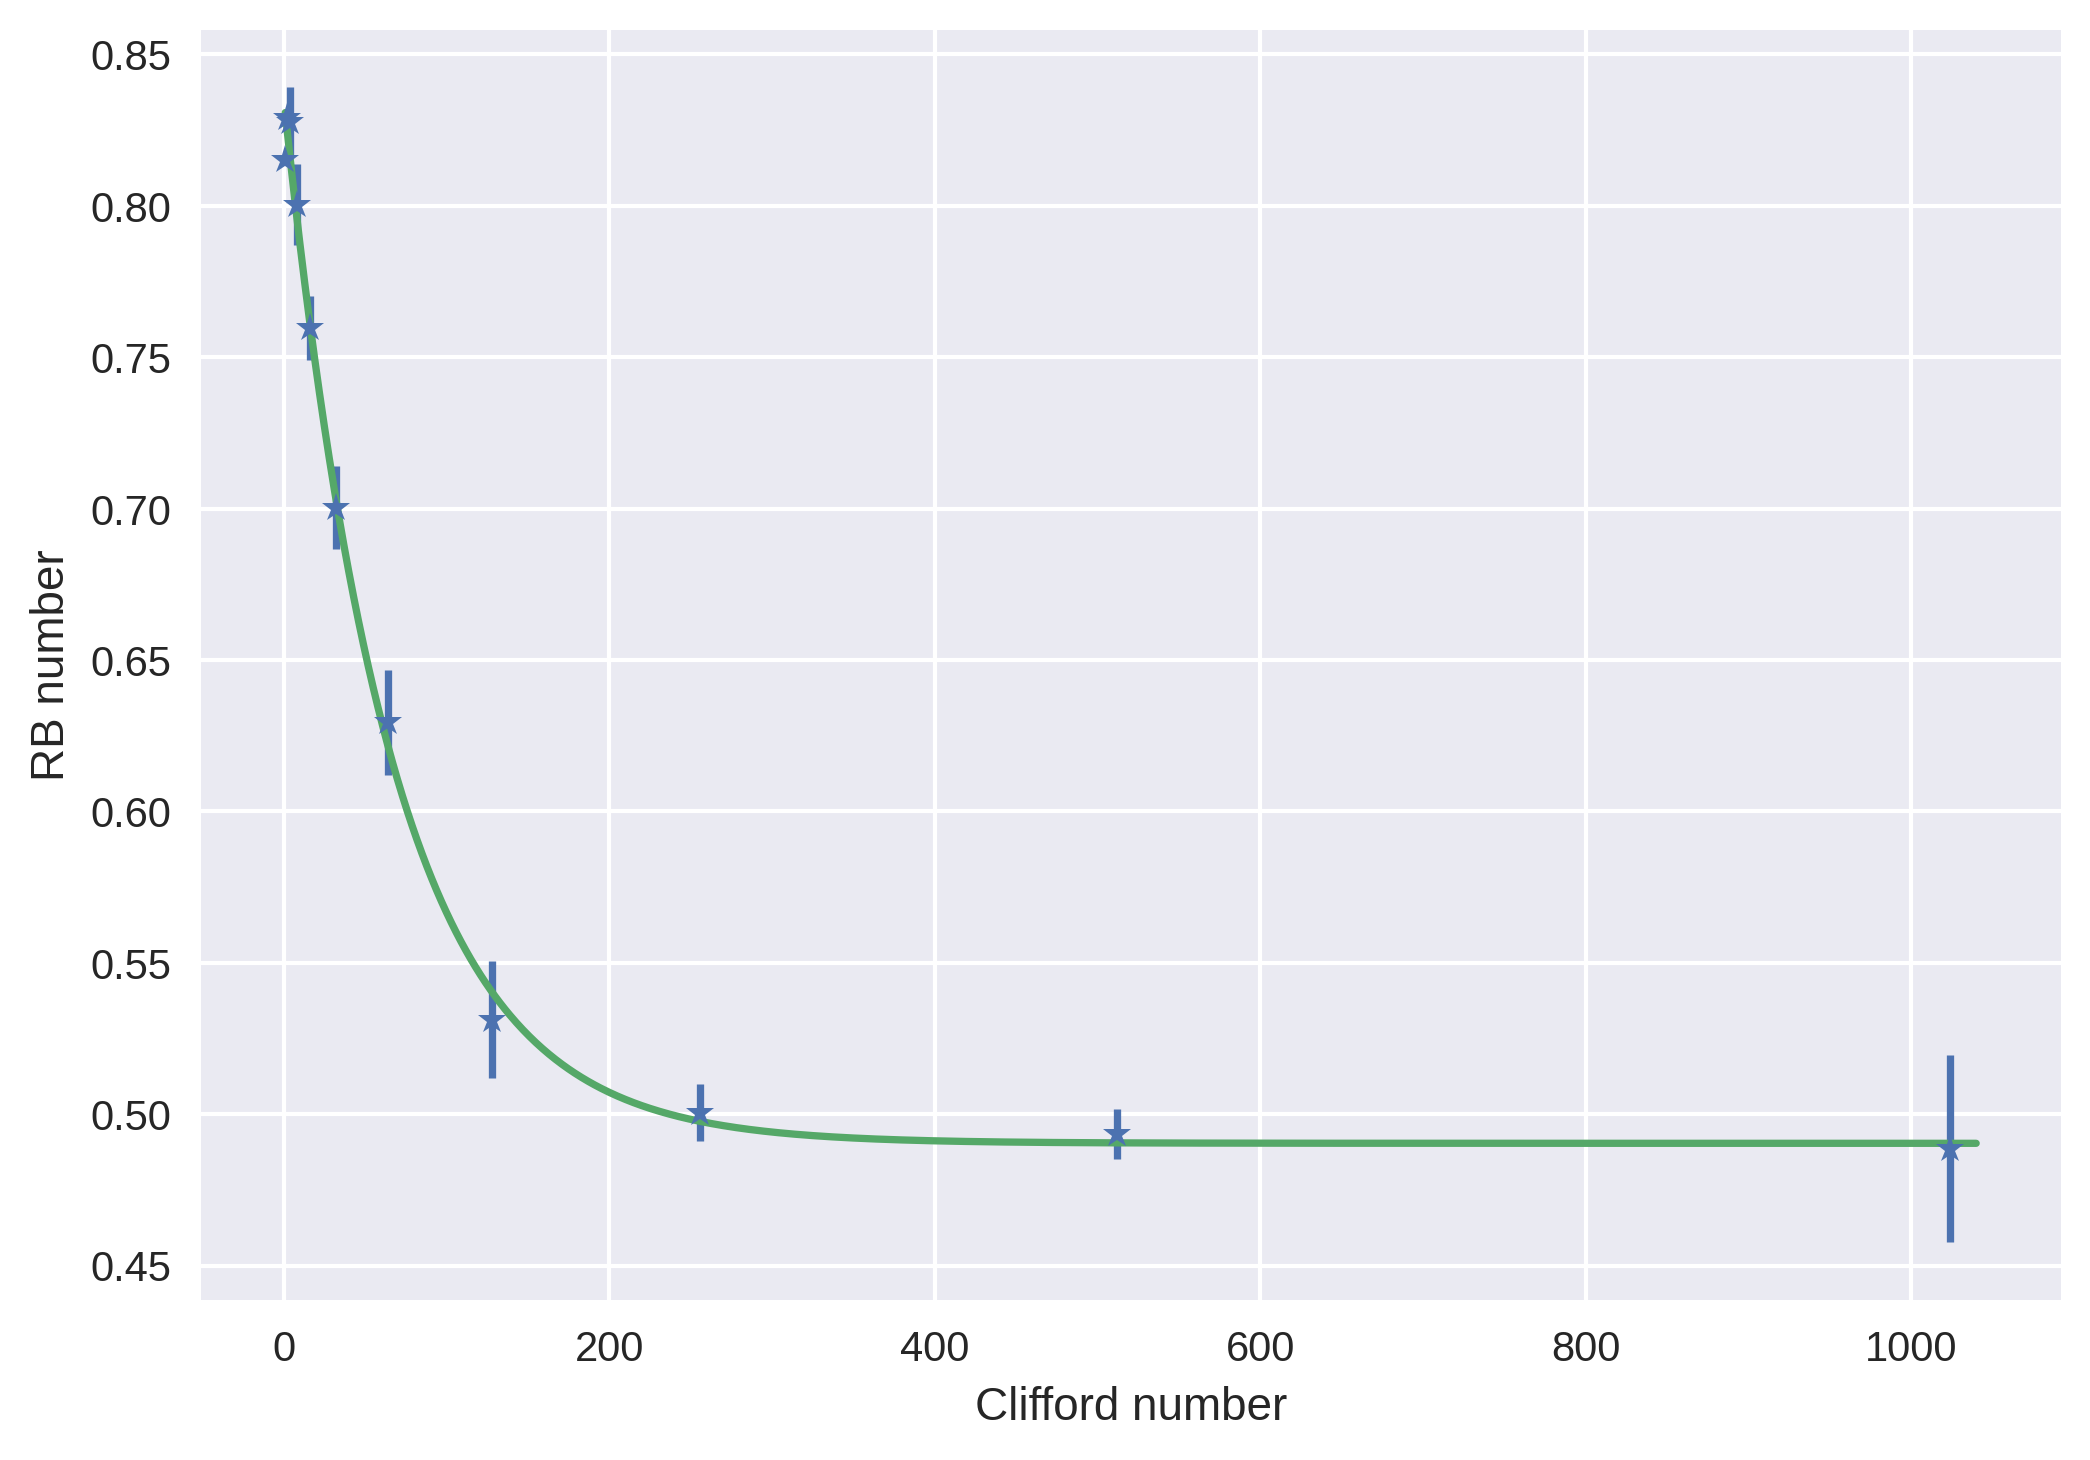

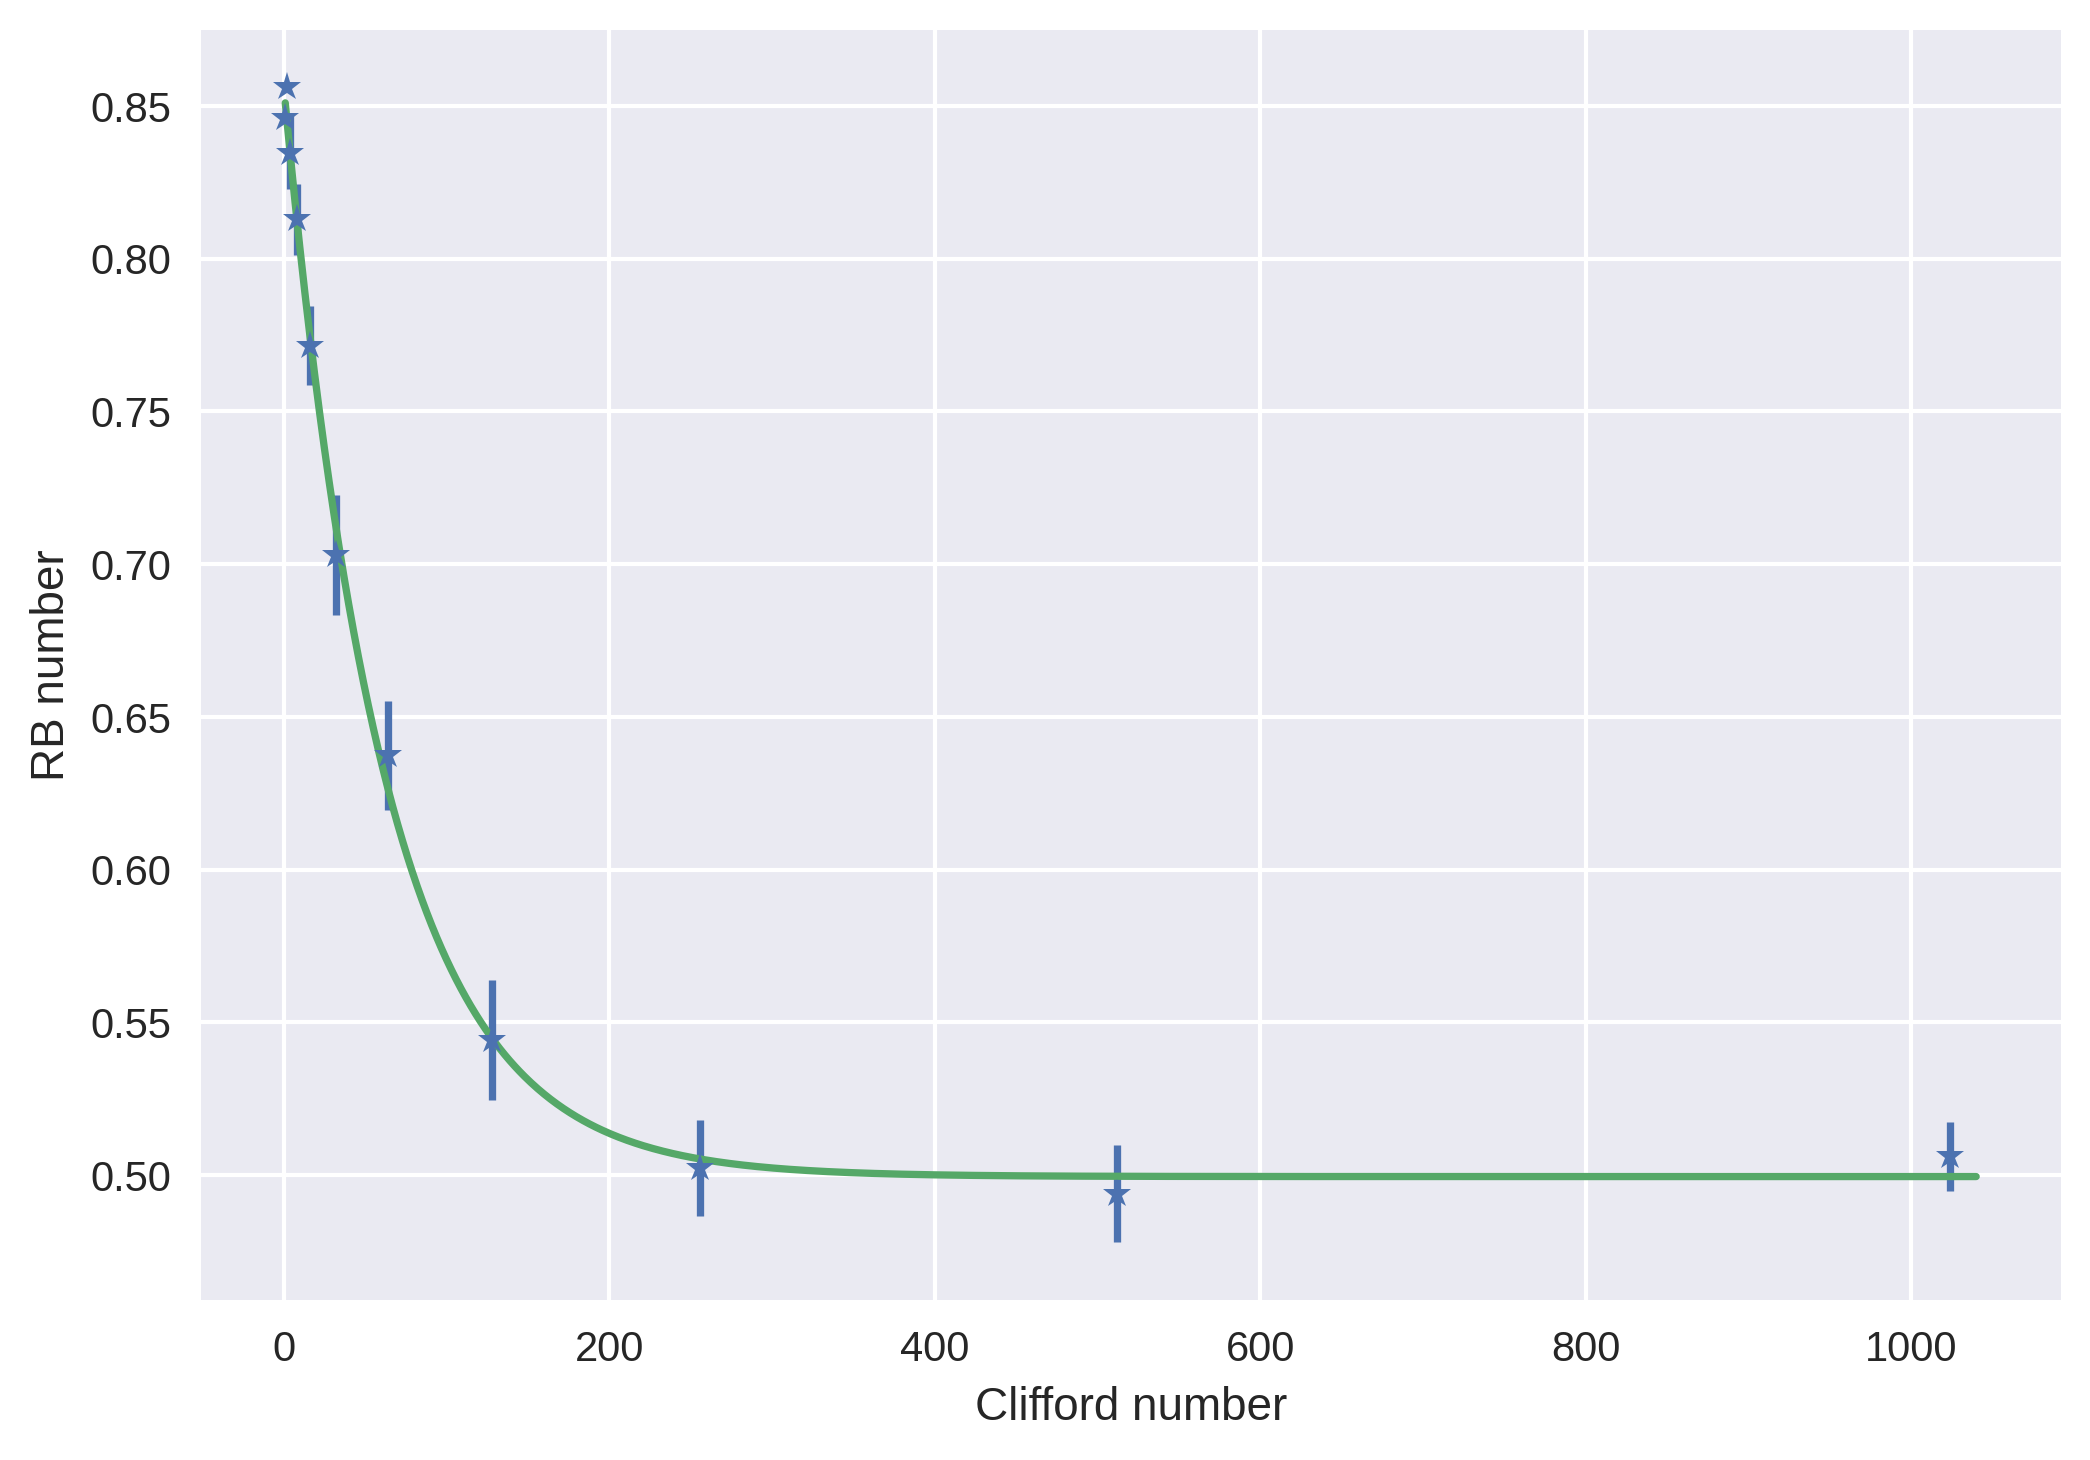

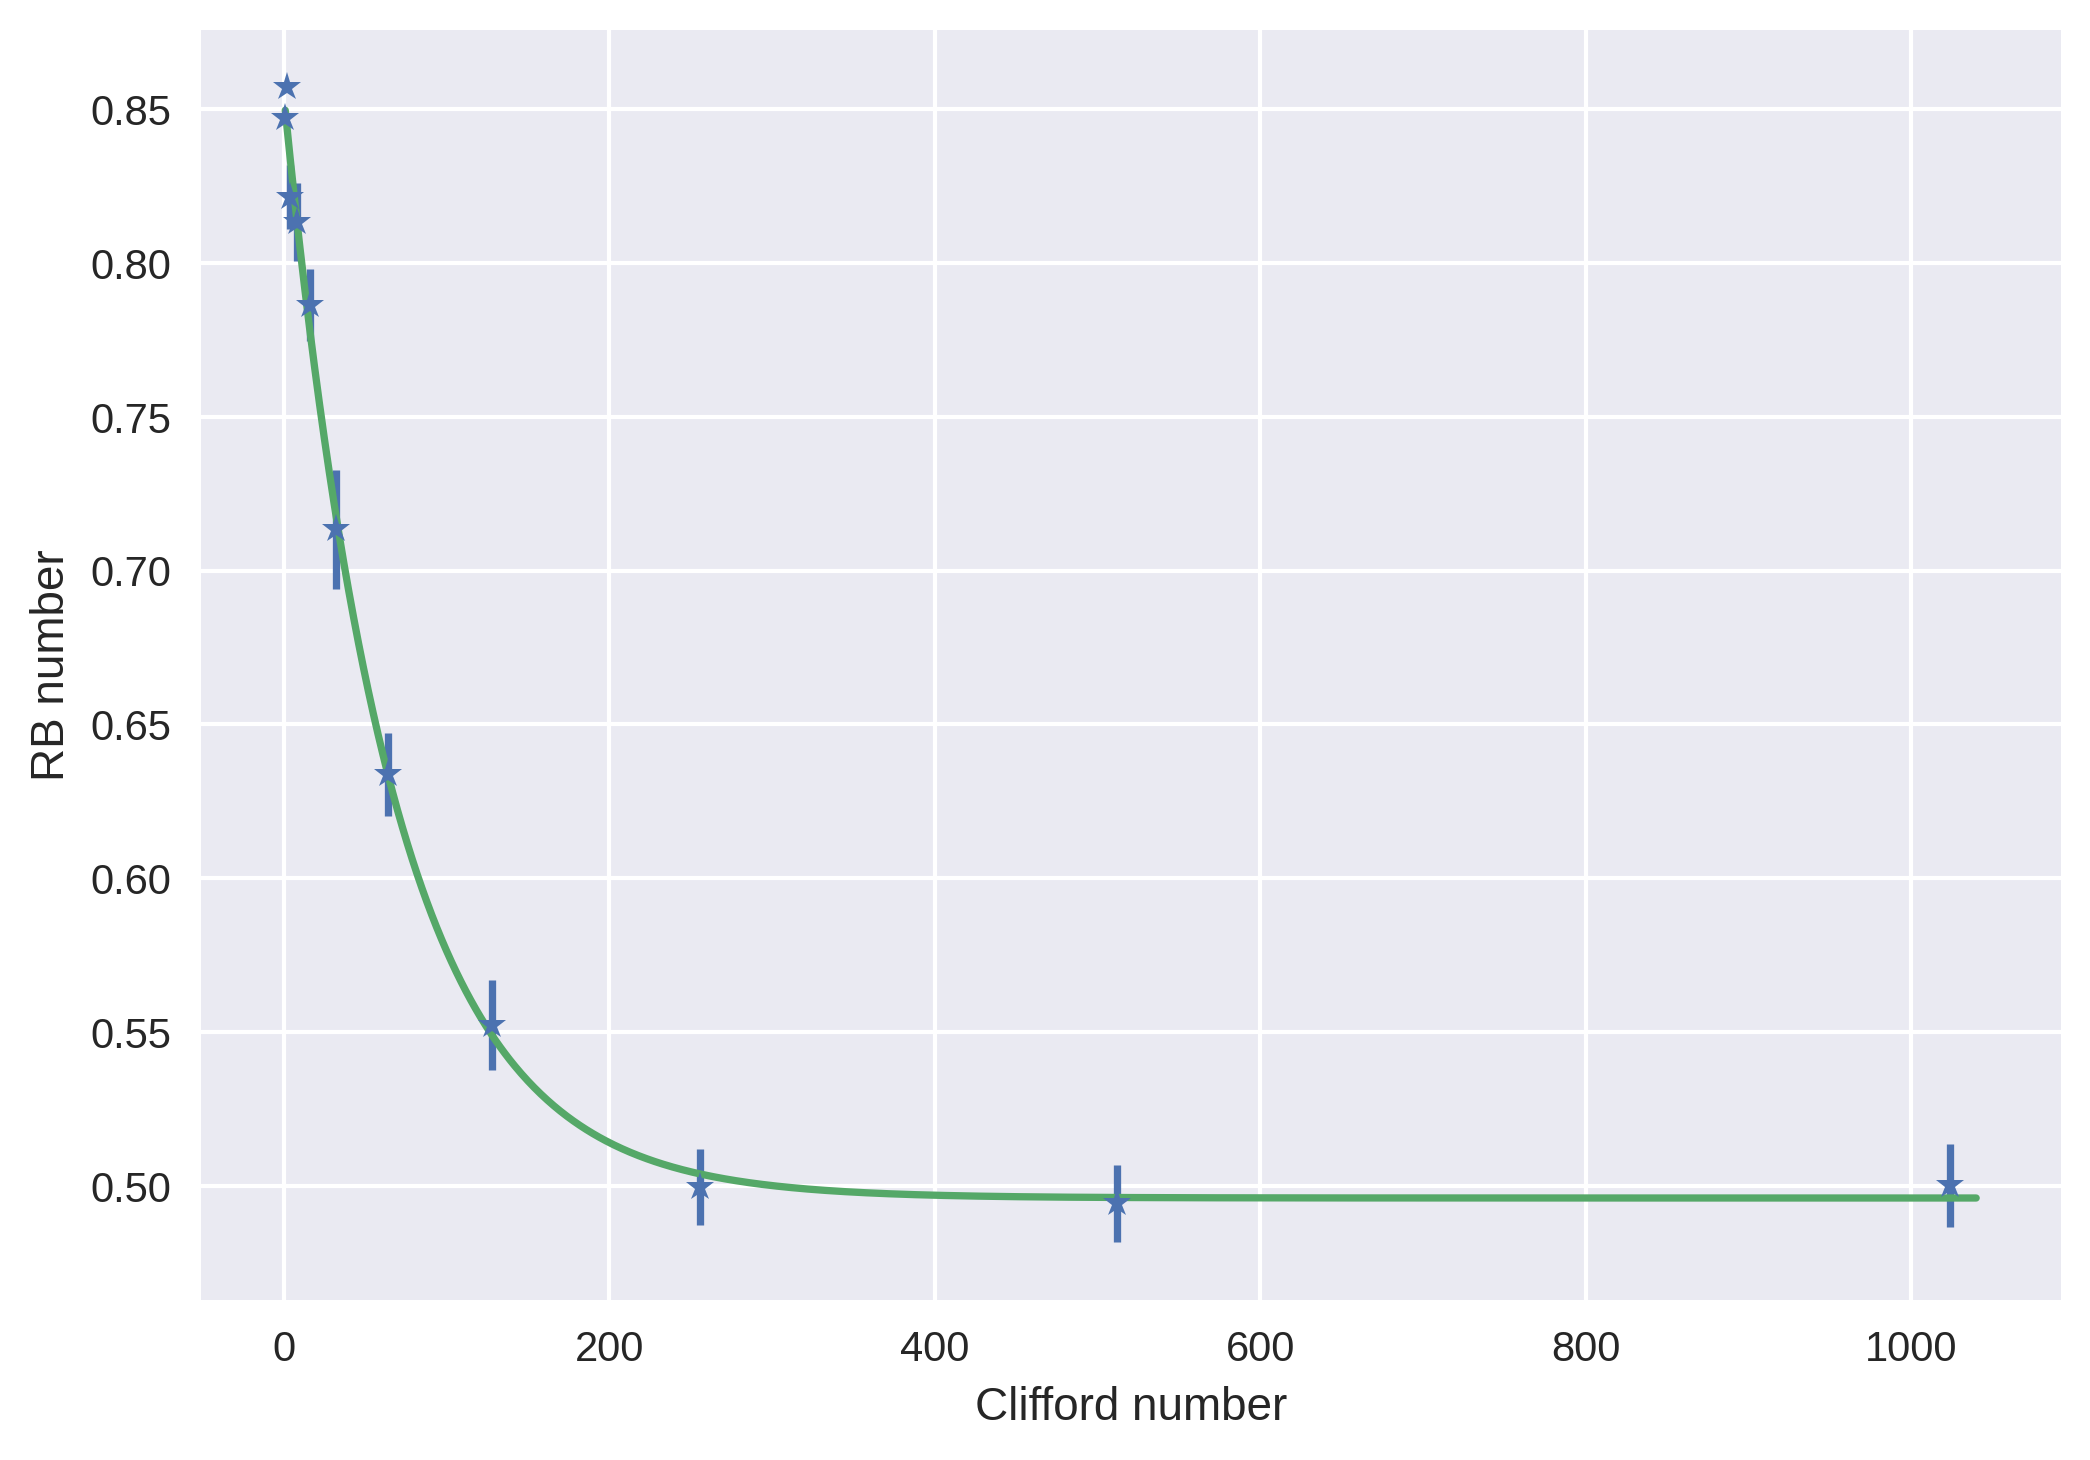

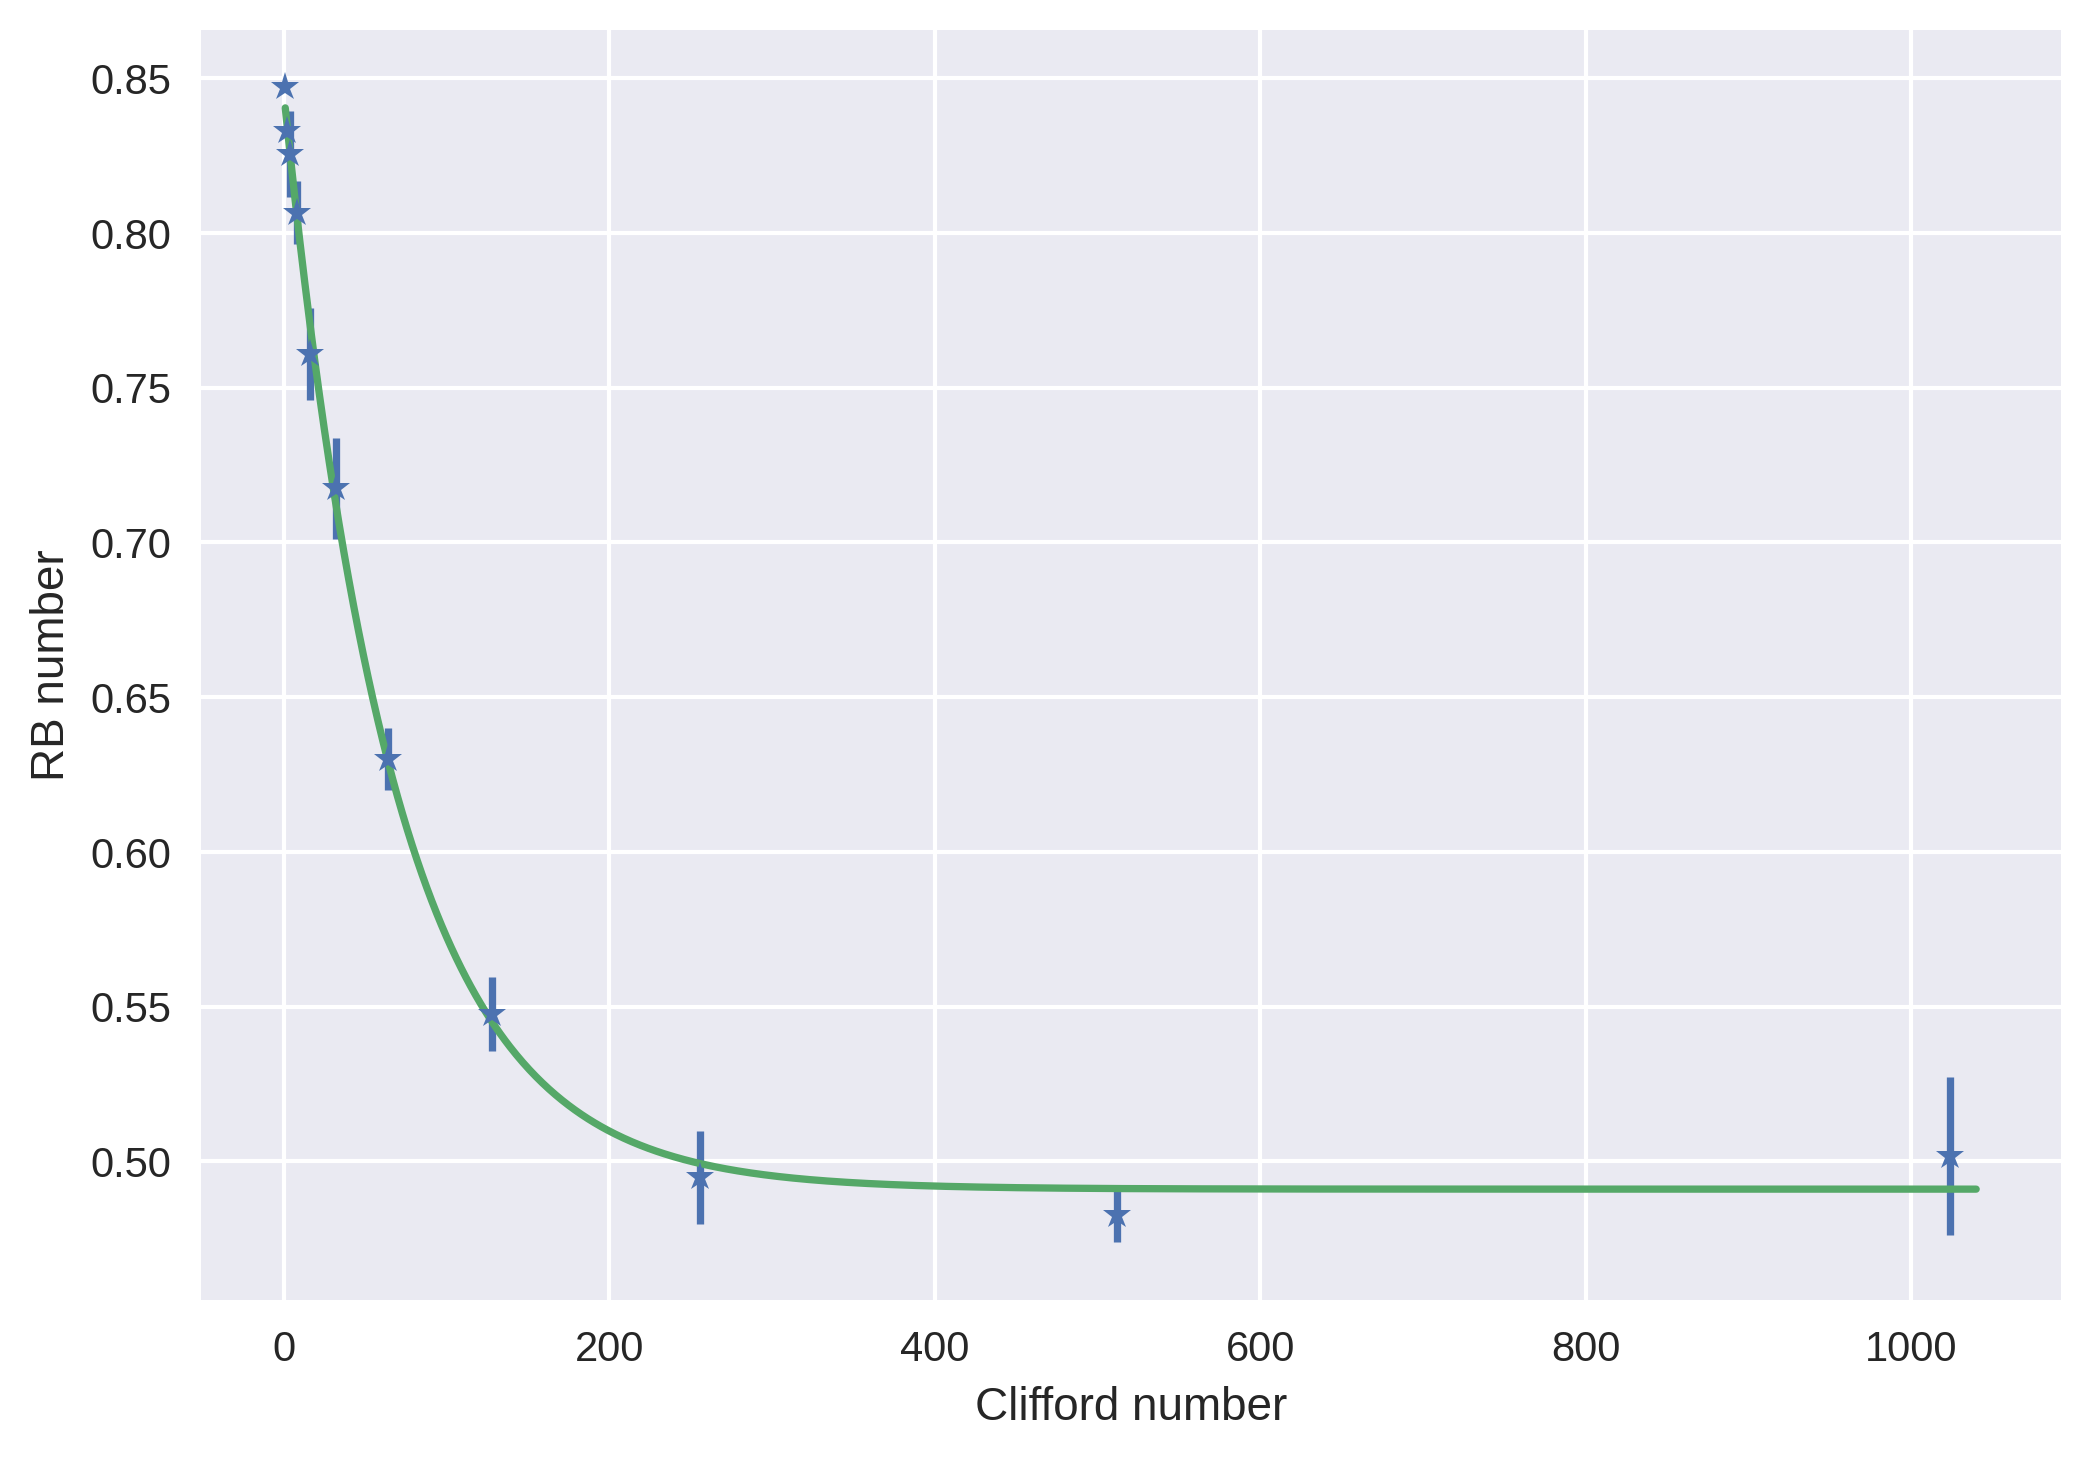

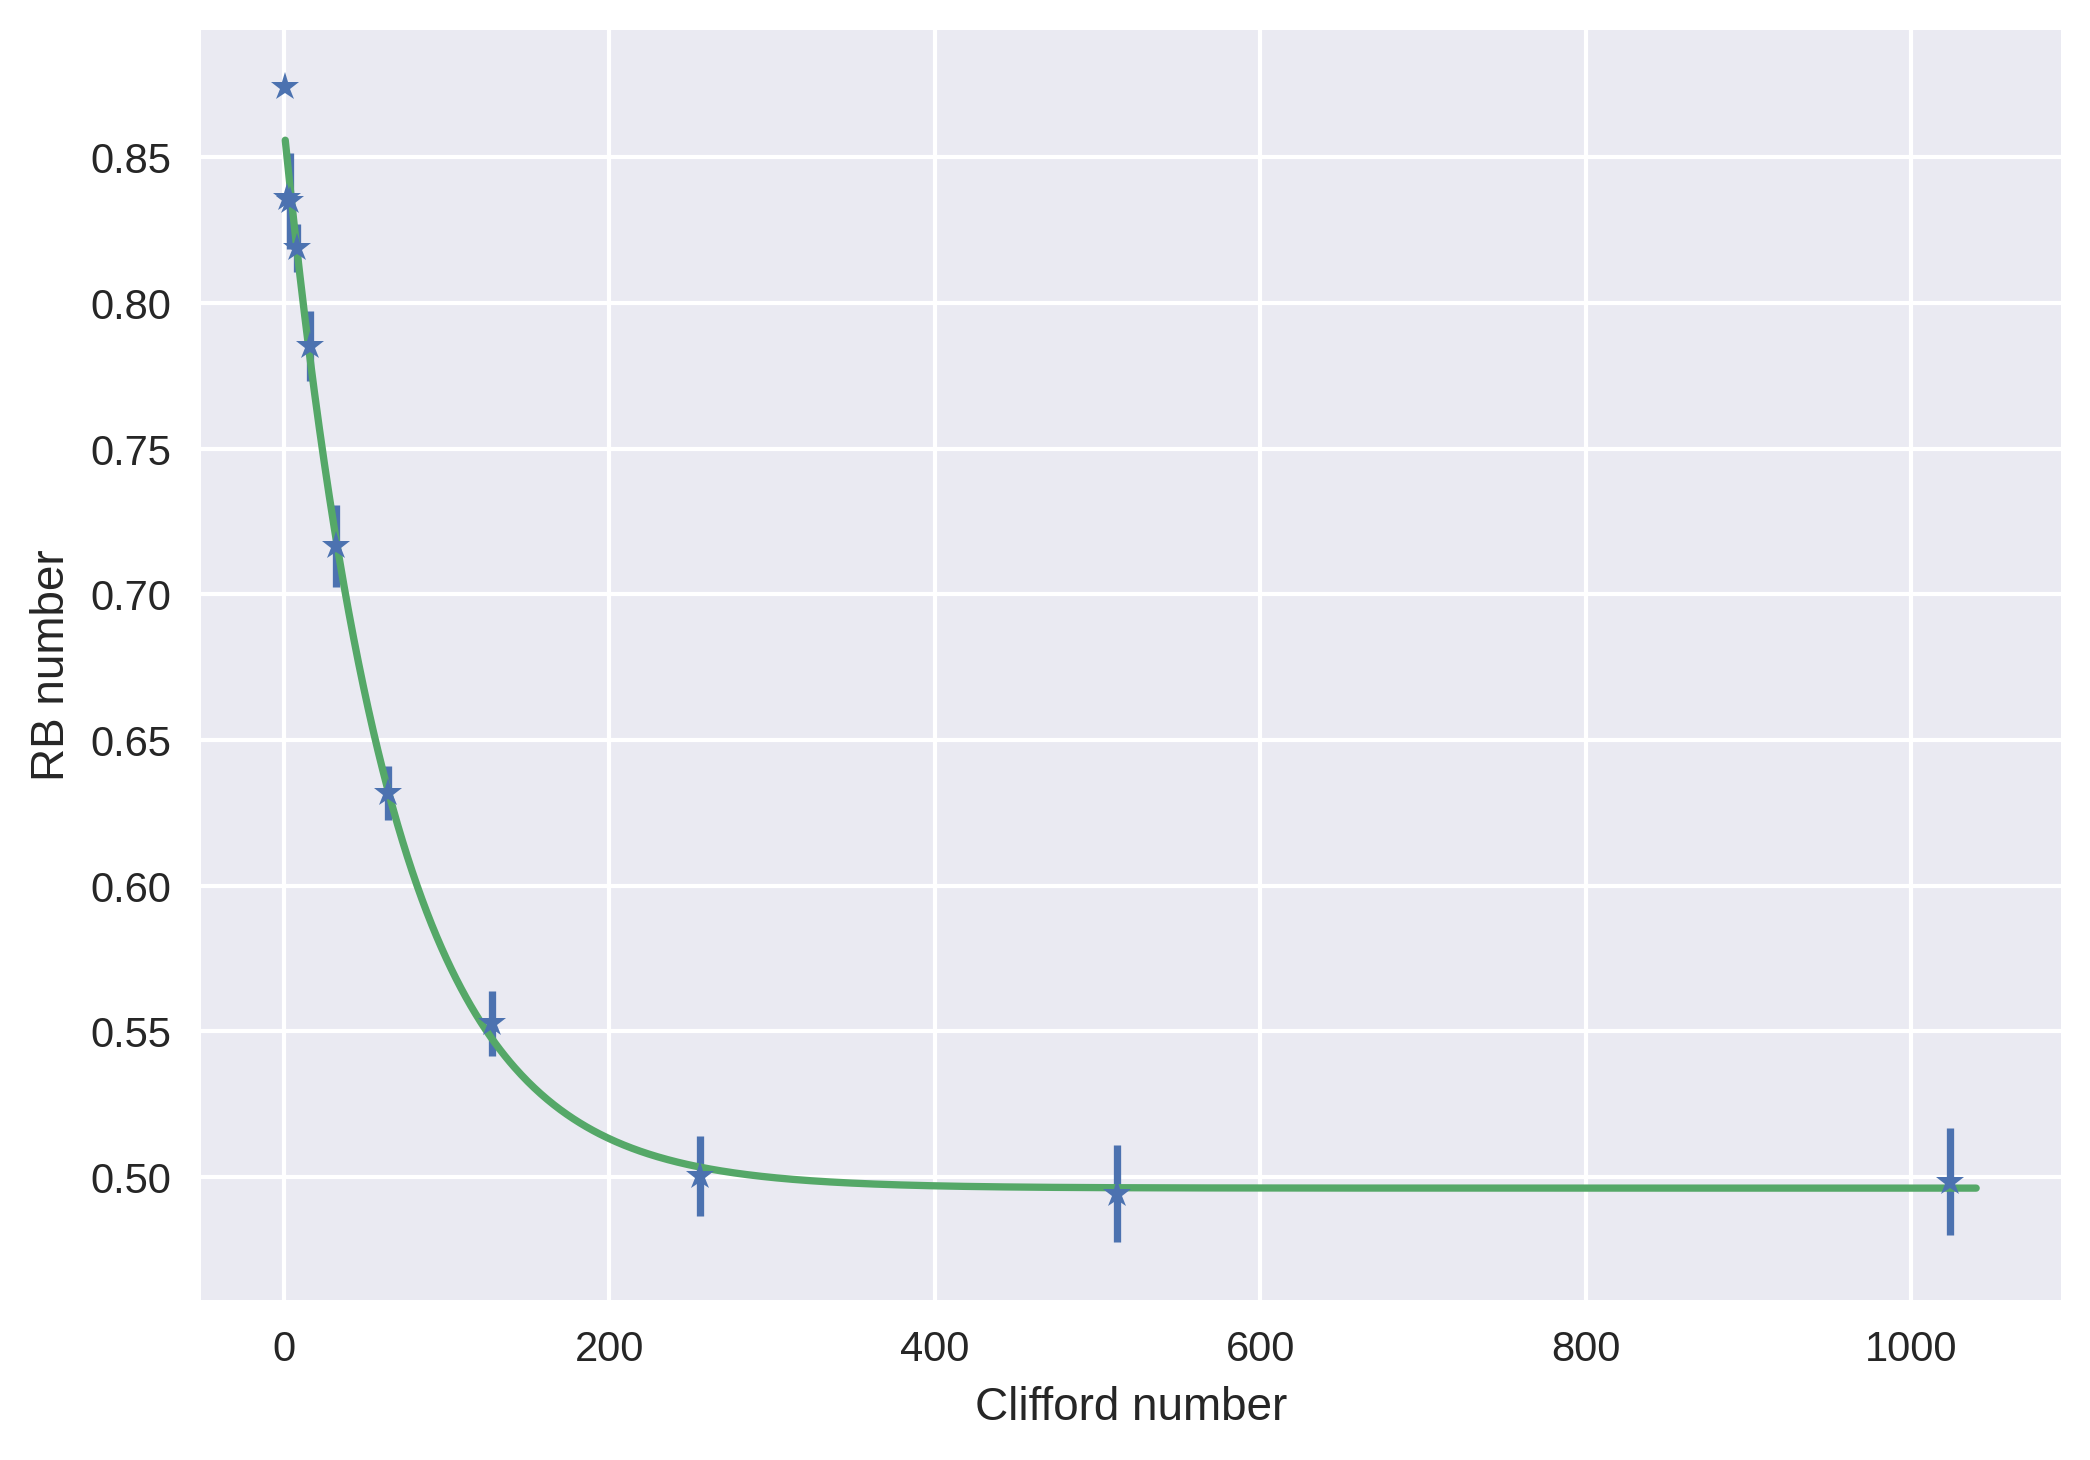

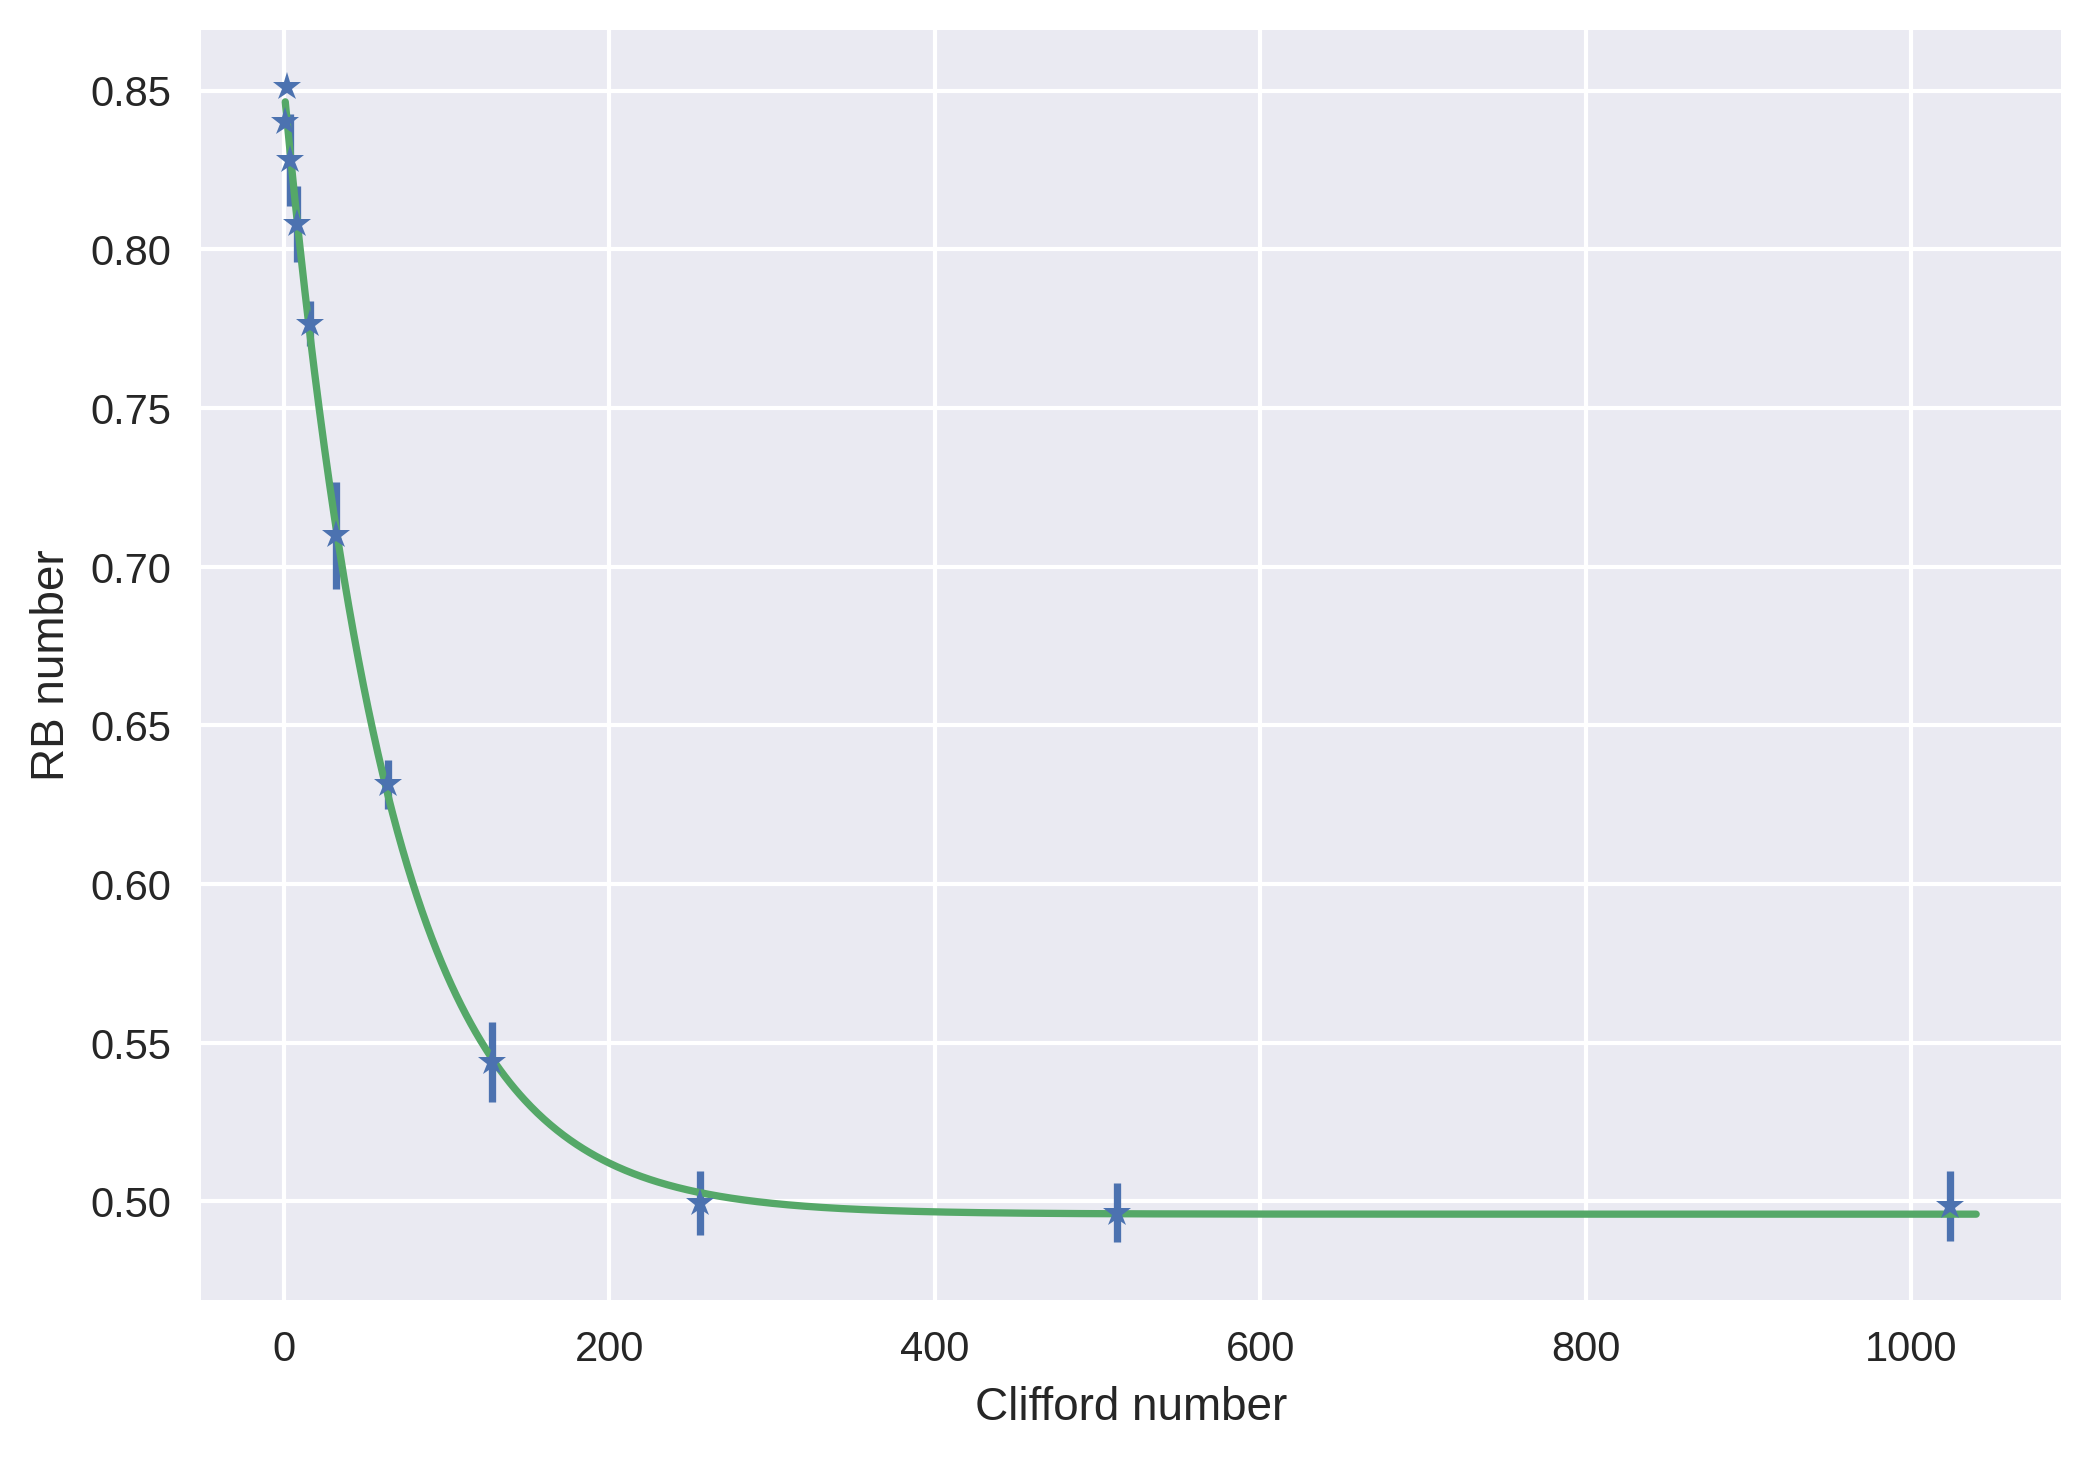

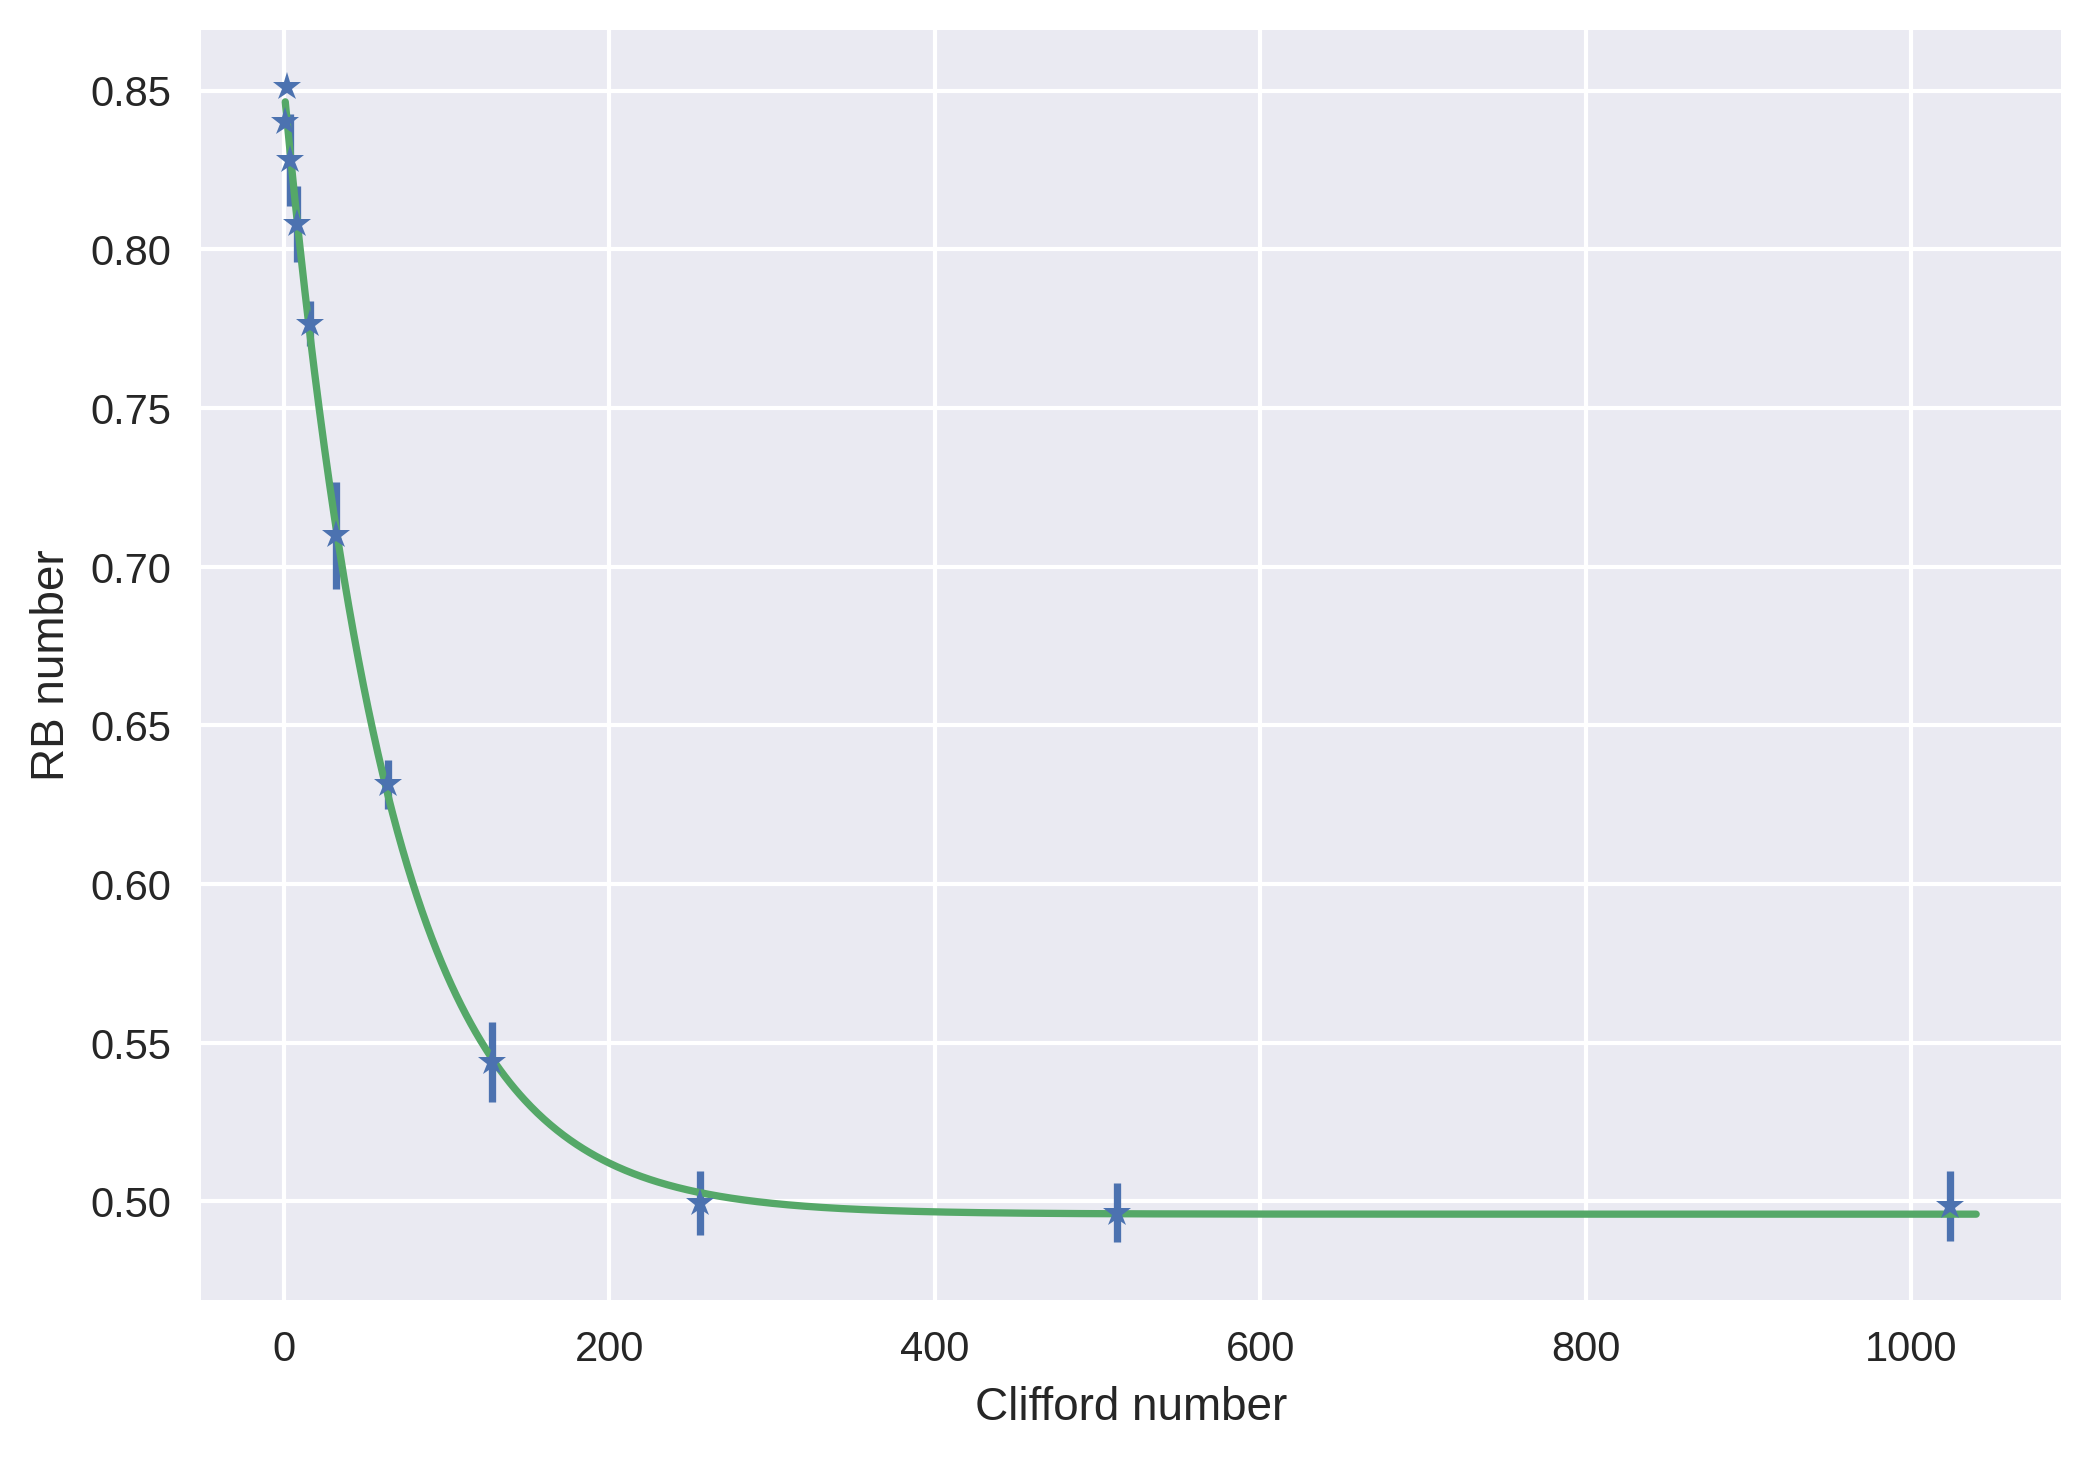

Found RB number 0.0076782099967172635 for file ../data/rgst_7.gst
Error: 0.00019780925119446894


In [18]:
infidelities = []
infid_err = []
for f in files
    circuits = readlines(f)[2:end] .|> s -> split(s, " ")[1];

    gsts = []
    for c in circuits
        # note the number match our mapping to each gate's enumeration 
        # in our set of Cliffords
        number_list = parse_gst(c, Dict("x"=>2,"y"=>5,"i"=>1,"{}"=>0))
        push!(gsts, number_list)
    end
    
    ind = []
    lengths = []
    # now on to experiments with non-zero length (that is why we start at index 2)

    # loop through all experiments
    for n in 2:length(gsts)
    #for n in 1:400
        # accumulate sequences
        inter = 1 # identity index
        for i in 1:length(gsts[n])
            inter   = multiply(gsts[n][i],inter)
        end
        if inter == 1 || inter == 9
            push!(ind, n)
            push!(lengths, length(gsts[n]))
        end

    end
    
    # collect and organize data
    minus_ct = readlines(f)[2:end] .|> s -> parse(Int, split(s, " ")[2]);
    mc = minus_ct[ind];
    pol = [mc[i] / 1000 for i in 1:length(mc)];
    data = sortrows(reshape([lengths; pol], length(lengths), 2));
    p2_data = data[ispow2.(data[:,1]),:];
    ddict = Dict{Int,Array{Float64}}()
    for i = 1:size(p2_data,1)
       v, y = p2_data[i,1], p2_data[i,2]
       if haskey(ddict, v)
            push!(ddict[v], y)
       else
           ddict[v] = [y]
       end
    end
    ddict = sort(ddict)
    
    # fit and plot
    figure()
    fit = fit_RB(collect(keys(ddict)), map(mean, collect(values(ddict))))
    errorbar(collect(keys(ddict)), 
             map(mean, collect(values(ddict))), 
             yerr=map(std, collect(values(ddict))), 
             linestyle="", marker="*")
    plot(1:1040, fit.fit_curve(1:1040))
    xlabel("Clifford number")
    ylabel("RB number")
    
    # save infidelity
    println("Found RB number ", fit.fit_params["b"] / 2, " for file $f")
    println("Error: ", fit.sq_error)
    push!(infidelities, fit.fit_params["b"] / 2)
    push!(infid_err, fit.sq_error)
end

In [9]:
infidelities

7-element Array{Any,1}:
 0.00749468
 0.00800273
 0.0074202 
 0.00728958
 0.00761136
 0.00767821
 0.00767821

In [19]:
infid_err

7-element Array{Any,1}:
 0.00059277 
 0.000450621
 0.000462189
 0.000391935
 0.000624883
 0.000197809
 0.000197809

Estimated $r = (d-1) * b / d$:

## GST infidelities

In [13]:
using Formatting, QuantumInfo, NPZ

INFO: Precompiling module Formatting.
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] uuid4(::MersenneTwister) at ./deprecated.jl:57
 [3] msg_header at /home/jovyan/.julia/v0.6/IJulia/src/msg.jl:18 [inlined]
 [4] msg_pub(::IJulia.Msg, ::String, ::Dict{String,String}, ::Dict{String,Any}) at /home/jovyan/.julia/v0.6/IJulia/src/msg.jl:30 (repeats 2 times)
 [5] send_stream(::String) at /home/jovyan/.julia/v0.6/IJulia/src/stdio.jl:172
 [6] send_stdio(::String) at /home/jovyan/.julia/v0.6/IJulia/src/stdio.jl:130
 [7] (::Base.##302#303{IJulia.#send_stderr,Timer})() at ./event.jl:436
while loading In[13], in expression starting on line 1
INFO: Precompiling module QuantumInfo.
INFO: Precompiling module NPZ.


In [14]:
target = Vector{Matrix{Complex128}}(3);
gst_gates = Matrix{Matrix{Complex128}}(3,7);
rgst_gates = Matrix{Matrix{Complex128}}(3,7);

for j in 1:7
    gst_result = npzread("../data/gst_$j.npz")
    rgst_result = npzread("../data/rgst_$j.npz")
    if j == 1
        for i in 1:3
            target[i] = gst_result["target"][i,:,:] |> pauliliou2liou
        end
    end
    for i in 1:3
        gst_gates[i,j]  = gst_result["final"][i,:,:] |> pauliliou2liou
        rgst_gates[i,j] = rgst_result["final"][i,:,:] |> pauliliou2liou
    end
end

gst_avgfid  = [avgfidelity(gst_gates[i,j],target[i]) for i in 1:3, j in 1:7];
gst_avgfid_ = reduce(hcat,[real.(npzread("../data/gst_$j.npz")["avgfid"]) for j in 1:7]);
gst_avgfid_err = reduce(hcat,[real.(npzread("../data/gst_$j.npz")["avgfiderr"]) for j in 1:7]);
rgst_avgfid = [avgfidelity(rgst_gates[i,j],target[i]) for i in 1:3, j in 1:7];
rgst_avgfid_ = reduce(hcat,[real.(npzread("../data/rgst_$j.npz")["avgfid"]) for j in 1:7]);
rgst_avgfid_err = reduce(hcat,[real.(npzread("../data/rgst_$j.npz")["avgfiderr"]) for j in 1:7]);

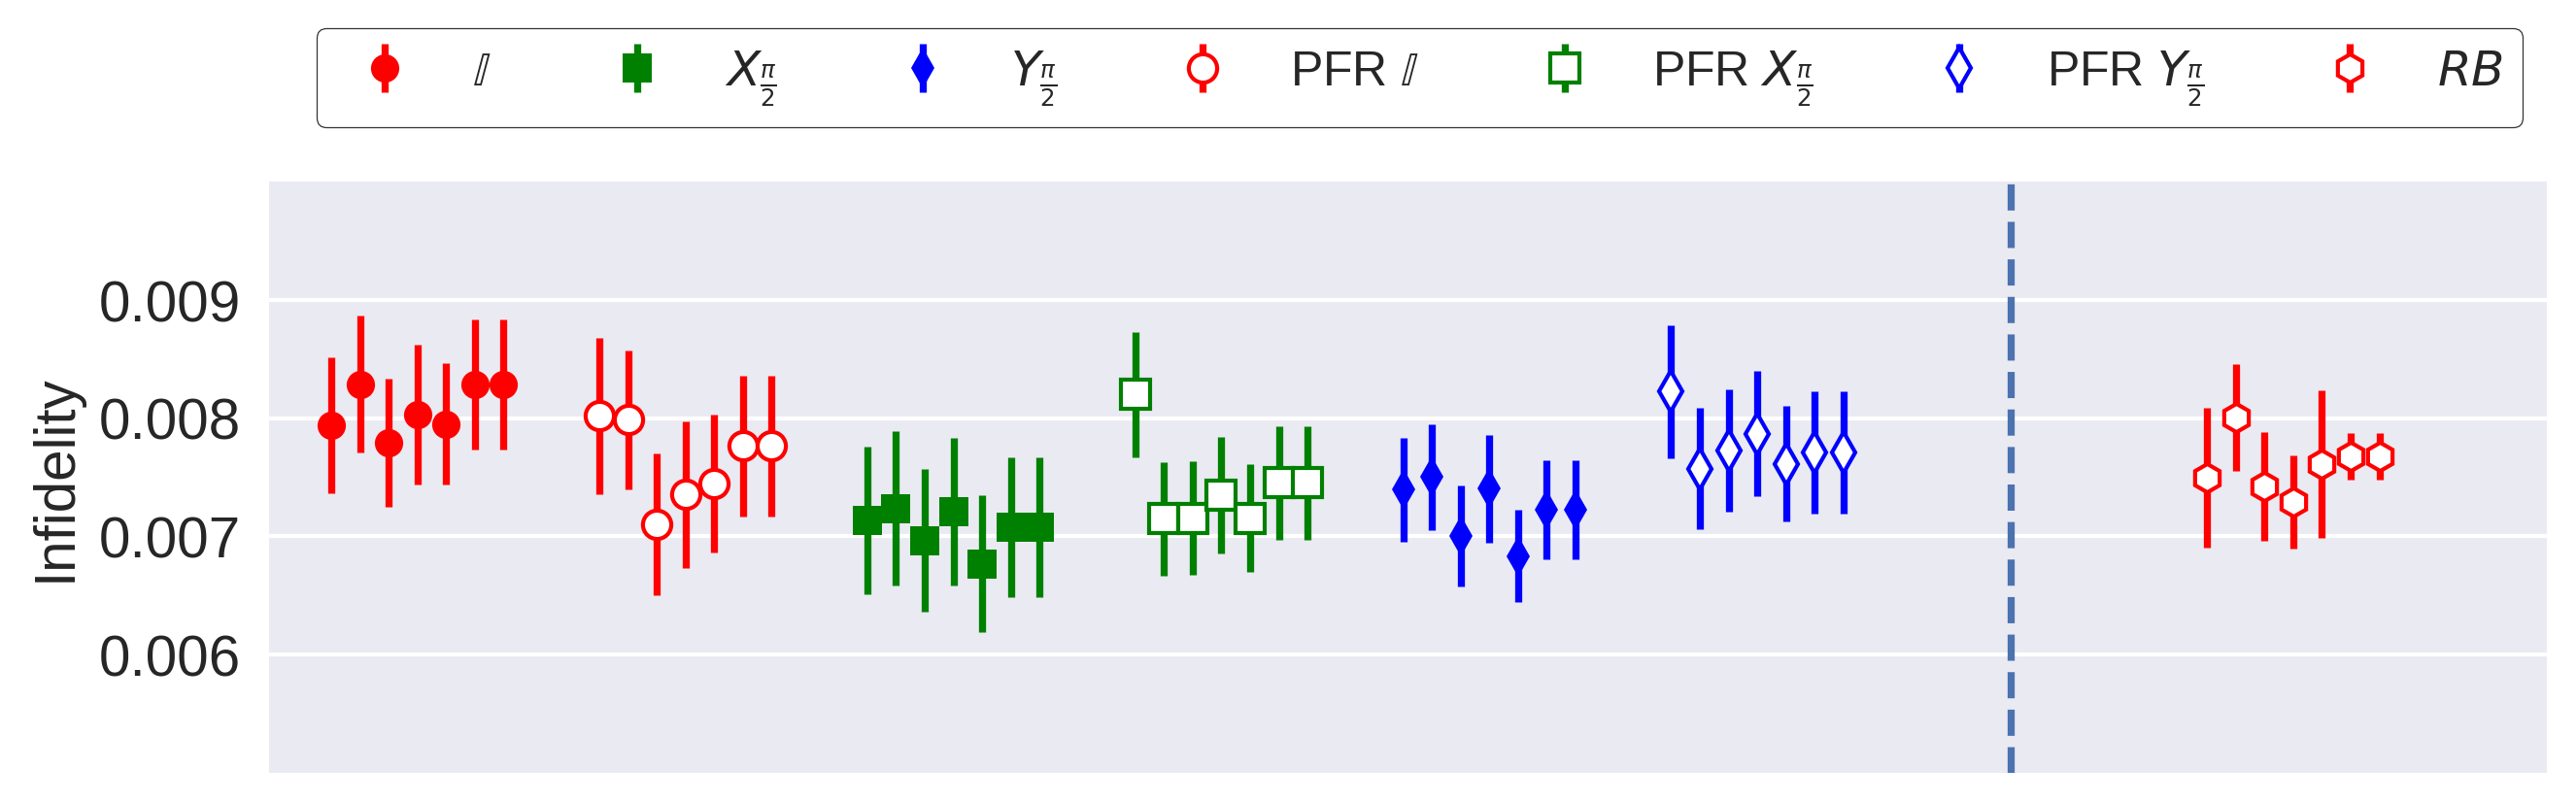

In [39]:
font_size = 14

figure(figsize=(9,3))

color = ["r","g","b"]
labels = [L"$\mathbb{I}$",L"$X_\frac{\pi}{2}$",L"$Y_\frac{\pi}{2}$"]
marker = ["o","s","d"]
for i=1:3
    errorbar(
        x=2*(i-1)+1.5+0.75/7*collect(1:7)-0.75/2,
        y=1-gst_avgfid'[1:7,i]|>vec,
        yerr=gst_avgfid_err[i,:],
        fmt="$(color[i])$(marker[i])",
        label=labels[i]
    )
end
for i=1:3
    errorbar(
        x=2*(i-1)+2.5+0.75/7*collect(1:7)-0.75/2,
        y=1-rgst_avgfid'[1:7,i]|>vec,
        yerr=rgst_avgfid_err[i,:],
        fmt="$(color[i])$(marker[i])",
        mfc="white",
        mew=1,
        label=latexstring("PFR ",labels[i])
    )
end
errorbar(
    x=8.5+0.75/7*collect(1:7)-0.75/2,
    y=infidelities,
    yerr=infid_err,
    fmt="rh",
    mfc="white",
    mew=1,
    label=latexstring("RB")
)
vlines(7.5, ymin=.005, ymax=.01, linestyles="dashed")
ylim([.005,.01])
yticks([0.006,0.007,0.008,0.009])

xlim([1,9.5])
xticks([])
ylabel("Infidelity", fontsize=font_size)
legend(bbox_to_anchor=(1, 1.3),
       fontsize=10.75,
       frameon=true,
       edgecolor="black",
       facecolor="white", 
       ncol=7,
       fontsize=12)

xticks(fontsize=font_size)
yticks(fontsize=font_size)

# annotate("(a)",
#             xy=(0.025,.96), xycoords="figure fraction",
#             horizontalalignment="left", verticalalignment="top",
#             fontsize=20)

tight_layout()
# savefig("../figs/RB_infidelity.pdf", dpi=600)